# Planning

In [2]:
# distance function
import os
os.chdir('C:/Users/clack/Projects/nwm')
from experiment.vae import Encoder


# encoder: 3x64x64 image -> 4x8x8 latent
# enc_block_config_str = '64x4,64d2,64t32,32x4,32d2,32t16,16x4,16d2,16t8,8x3'
# enc_channel_config_str = '64:128,32:256,16:512,8:512'
def make_distance_function():
  return Encoder(
    block_config_str='8x4,8d2,8t4,4x4,4d4,4t1,1x4',
    channel_config_str='8:64,4:256,1:512',
    bottleneck_channels=16,
    image_channels=8
  )

In [ ]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from typing import Callable, List, Tuple

from experiment.vae import make_vae


transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
def denormalize(tensor, mean=0.5, std=0.5):
    return tensor * std + mean

class OnDemandDataset(torchvision.datasets.VisionDataset):
  def __init__(self, size: int, sample: Callable[[], torch.Tensor], transform = None):
    super().__init__(transform=transform)
    self.size = size
    self.sample = sample

  def __len__(self):
    return self.size
  
  def __getitem__(self, _) -> torch.Tensor:
    return self.transform(self.sample()) if self.transform else self.sample()
  
from experiment.nav2d import Topo

vae = make_vae()
vae.load_state_dict(torch.load('checkpoints/vae/topo/check59.pt'))

def sample():
  camera_size = 64
  state = Topo.random(avoid_wall_start=False)
  offset_upper_bound = state.terrain_size // 2 - camera_size // 2
  biased_upper_bound = np.random.rand() * offset_upper_bound

  image1 = state.render(camera_size)
  image1 = torch.from_numpy(image1).permute(2, 0, 1).to(torch.float32)

  # disproportionately sample small offsets
  offset = biased_upper_bound * (np.random.rand(2) * 2 - 1)
  state.position += offset
  image2 = state.render(camera_size)
  image2 = torch.from_numpy(image2).permute(2, 0, 1).to(torch.float32)
  
  latent1, latent2 = vae.encode(torch.stack((image1, image2)))
  return latent1, latent2, offset
import time
def shortest_path(
  state: Topo, start: np.ndarray, end: np.ndarray, max_distance: float | None = None
) -> Tuple[List[np.ndarray], float] | None:
  start_block = start.round().astype(np.uint32)
  end_block = end.round().astype(np.uint32)
  if max_distance is None:
    max_distance = float((np.abs(end_block - start_block).sum() * 2).item())

  distance = np.full((state.terrain_size, state.terrain_size), max_distance, dtype=np.float32)
  distance[start_block[1], start_block[0]] = 0

  edges = np.array(
    [np.array([0, 1]), np.array([1, 0]), np.array([0, -1]), np.array([-1, 0])]
    + [np.array([1, 1]), np.array([1, -1]), np.array([-1, 1]), np.array([-1, -1])]
  )
  edge_lengths = np.array([1] * 4 + [2**0.5] * 4)

  shortest_distance_found = max_distance
  heads = [start_block]
  while heads:
    head = heads.pop(0)
    distance_from_start = distance[head[1], head[0]]
    if distance_from_start >= shortest_distance_found:
      continue
    if np.equal(head, end_block).all() and distance_from_start < shortest_distance_found:
      shortest_distance_found = distance_from_start.item()
      print('adsakjdksajdlsakjdk')
      continue

    neighbors = head[None, :] + edges
    out_of_bounds = (neighbors < 0).any(-1) | (neighbors >= state.terrain_size).any(-1)
    neighbors = neighbors[~out_of_bounds]

    estimated_neighbor_distances = distance_from_start + edge_lengths[~out_of_bounds]
    dead_end = (
      (state.terrain[neighbors[:, 1], neighbors[:, 0]] >= state.wall_height)  # neighbor is a wall
      | (estimated_neighbor_distances >= distance[neighbors[:, 1], neighbors[:, 0]])  # neighbor already has a closer estimate
      | (estimated_neighbor_distances > max_distance)  # neighbor is too far away from the start
      | (np.abs(neighbors - end_block[None, :]).sum() > max_distance)  # neighbor is too far from the goal anyway
    )
    neighbors = neighbors[~dead_end]
    distance[neighbors[:, 1], neighbors[:, 0]] = estimated_neighbor_distances[~dead_end]
    heads.extend(neighbors)

  # no path found
  if shortest_distance_found == max_distance:
    return None

  # reconstruct a shortest path
  path = [end_block]
  while not np.equal(path[-1], start_block).all():
    neighbors = [path[-1] + edge for edge in edges]
    neighbor_closest_to_start = neighbors[np.argmin(np.array([distance[neighbor[1], neighbor[0]] for neighbor in neighbors]))]
    path.append(neighbor_closest_to_start)
  return list(reversed(path)), shortest_distance_found


def nav2d_dataset(size: int):
  return OnDemandDataset(
    size=size,
    sample=sample,
    transform=transform
  )
trainloader = torch.utils.data.DataLoader(nav2d_dataset(1000), batch_size=16, shuffle=True)

In [164]:
np.arange(10)[~np.zeros(10, dtype=np.bool)]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

[array([128, 128], dtype=uint32)]
[array([128, 129]), array([129, 128]), array([128, 127]), array([127, 128]), array([129, 129]), array([129, 127]), array([127, 129]), array([127, 127])]
[array([129, 128]), array([128, 127]), array([127, 128]), array([129, 129]), array([129, 127]), array([127, 129]), array([127, 127]), array([128, 130]), array([129, 129]), array([128, 128]), array([127, 129]), array([129, 130]), array([129, 128]), array([127, 130]), array([127, 128])]
[array([128, 127]), array([127, 128]), array([129, 129]), array([129, 127]), array([127, 129]), array([127, 127]), array([128, 130]), array([129, 129]), array([128, 128]), array([127, 129]), array([129, 130]), array([129, 128]), array([127, 130]), array([127, 128]), array([129, 129]), array([130, 128]), array([129, 127]), array([128, 128]), array([130, 129]), array([130, 127]), array([128, 129]), array([128, 127])]
[array([127, 128]), array([129, 129]), array([129, 127]), array([127, 129]), array([127, 127]), array([128, 

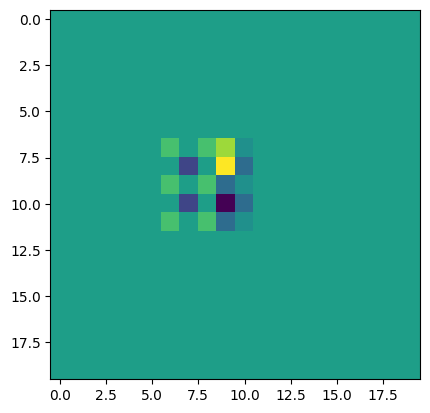

In [ ]:
import matplotlib.pyplot as plt
state = Topo.random()
start_time = time.perf_counter()
path = shortest_path(state, np.array([128, 128]), np.array([129, 129]))
print(time.perf_counter() - start_time)
plt.imshow(path[120:140, 120:140])

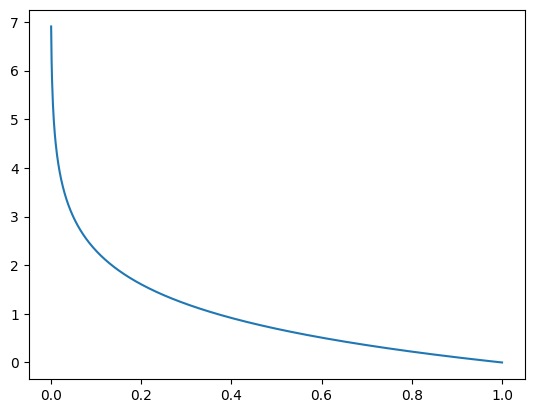

In [6]:
import matplotlib.pyplot as plt
z = np.linspace(0.001, 1, 1000)
plt.plot(z, -np.log(z)) 